In [1]:

import matplotlib.pyplot as plt
import numpy as np

import math
import sys
import os

from pathlib import Path

this_dir = str(Path.cwd())
sys.path.append(this_dir + '/../')

import tvector_pybind, scene_pybind, photon_pybind, phase_pybind, medium_pybind, image_pybind

In [2]:

outFilePrefix = 'USOCTRendering'

# default film parameters
pathLengthMin = 0
pathLengthMax = 64
pathLengthBins = 128
spatialX = 128
spatialY = 128

# adhoc parameters
halfThetaLimit = 12.8e-3
emitter_size = 0.002
sensor_size = 0.002
emitter_distance = 0.0
sensor_distance = 0.0

# default scattering parameters
sigmaT = 0.0
albedo = 1.0
gVal = 0.0


# default scene parameters
ior = 1.333
mediumL = tvector_pybind.Vec3f(-0.015, -5.0, -5.0)
mediumR = tvector_pybind.Vec3f( 0.015,  5.0,  5.0)

# default rendering parameters
numPhotons = 10000
maxDepth = -1
maxPathLength = -1
useDirect = False
useAngularSampling = True

# default final path importance sampling parameters
distribution = "vmf"
gOrKappa = 4
emitter_lens_aperture = .015
emitter_lens_focalLength = .015
emitter_lens_active = False

sensor_lens_aperture = .015
sensor_lens_focalLength = .015
sensor_lens_active = False

printInputs = True

f_u = 5*1e6
speed_u = 1500
n_o = 1.3333
n_scaling = 0.05e-3
n_coeff = 1
radius = 2 * 25.4e-3
center1 = tvector_pybind.Vec3f(-radius, 0., 0)
center2 = tvector_pybind.Vec3f(-radius, 0., 0)
active1 = True
active2 = True
phase1 = 0
phase2 = 0
chordlength = 0.5 * 25.4e-3
theta_min = -math.asin(chordlength/(2*radius))
theta_max =  math.asin(chordlength/(2*radius))
theta_sources = 100
trans_z_min = -chordlength/2
trans_z_max =  chordlength/2
trans_z_sources = 51

emitter_gap = .0
sensor_gap = .0
er_stepsize = 1e-3
precision = 4
directTol = 1e-5
useInitializationHack = True
rrWeight = 1e-2

useBounceDecomposition = True
projectorTexture = "/home/apedired/Dropbox/AccoustoOptics+InvRendering/CodeEtc/SkeletalRenderer/ercrdr/renderer/images/White.pfm"

threads = -1
printInputs = False 
# WIP to read defaults from a file
# read in custom parameters, if any
#print('Reading custom parameters...')
custom_params_f = open(this_dir + '/renderer3d_sample_input.txt')
for line in custom_params_f:
    #print('\t%s' %(line.strip()))
    param, value = line.strip().split('=')
    if value == '': continue
    if param == 'threads': threads = int(value)
    elif param == 'precision': precision = int(value)
    elif param == 'numPhotons': numPhotons = int(value)
    elif param == 'outFilePrefix': outFilePrefix = value
    elif param == 'sigmaT': sigmaT = float(value)
    elif param == 'albedo': albedo = float(value)
    elif param == 'gVal': gVal = float(value)
    elif param == 'f_u': f_u = float(value)
    elif param == 'speed_u': speed_u = float(value)
    elif param == 'n_o': n_o = float(value)
    elif param == 'n_scaling': n_scaling = float(value)
    elif param == 'n_coeff': n_coeff = int(value)
    elif param == 'radius': radius = float(value)
    elif param == 'center1': center1 = tvector_pybind.Vec3f(float(value.strip().split(',')[0]), float(value.strip().split(',')[1]), float(value.strip().split(',')[2]))
    elif param == 'center2': center2 = tvector_pybind.Vec3f(float(value.strip().split(',')[0]), float(value.strip().split(',')[1]), float(value.strip().split(',')[2]))
    elif param == 'active1': active1 = (value == 'True')
    elif param == 'active2': active2 = (value == 'True')
    elif param == 'phase1': phase1 = float(value)
    elif param == 'phase2': phase2 = float(value)
    elif param == 'chordlength': chordlength = float(value)
    elif param == 'theta_sources': theta_sources = int(value)
    elif param == 'trans_z_sources': trans_z_sources = int(value)
    elif param == 'er_stepsize': er_stepsize = float(value)
    elif param == 'directTol': directTol = float(value)
    elif param == 'rrWeight': rrWeight = float(value)
    elif param == 'projectorTexture': projectorTexture = value
    elif param == 'useDirect': useDirect = (value == 'True')
    elif param == 'useAngularSampling': useAngularSampling = (value == 'True')
    elif param == 'useBounceDecomposition': useBounceDecomposition = (value == 'True')
    elif param == 'maxDepth': maxDepth = int(value)
    elif param == 'maxPathlength': maxPathlength = float(value)
    elif param == 'pathLengthMin': pathLengthMin = float(value)
    elif param == 'pathLengthMax': pathLengthMax = float(value)
    elif param == 'pathLengthBins': pathLengthBins = int(value)
    elif param == 'spatialX': spatialX = int(value)
    elif param == 'spatialY': spatialY = int(value)
    elif param == 'mediumLx': mediumLx = float(value)
    elif param == 'mediumRx': mediumRx = float(value)
    elif param == 'distribution': distribution = value
    elif param == 'gOrKappa': gOrKappa = float(value)
    elif param == 'halfThetaLimit': halfThetaLimit = float(value)
    elif param == 'emitter_gap': emitter_gap = float(value)
    elif param == 'sensor_gap': sensor_gap = float(value)
    elif param == 'emitter_size': emitter_size = float(value)
    elif param == 'emitter_distance': emitter_distance = float(value)
    elif param == 'emitter_lens_aperture': emitter_lens_aperture = float(value)
    elif param == 'emitter_lens_focalLength': emitter_lens_focalLength = float(value)
    elif param == 'emitter_lens_active': emitter_lens_active = (value == 'True')
    elif param == 'sensor_size': sensor_size = float(value)
    elif param == 'sensor_distance': sensor_distance = float(value)
    elif param == 'sensor_lens_aperture': sensor_lens_aperture = float(value)
    elif param == 'sensor_lens_focalLength': sensor_lens_focalLength = float(value)
    elif param == 'sensor_lens_active': sensor_lens_active = (value == 'True')
    elif param == 'useInitializationHack': useInitializationHack = (value == 'True')
    elif param == 'printInputs': printInputs = value
    else: print('\tError: \'%s\' is not a valid parameter' %param)

if printInputs:
    print('threads:' + str(threads))
    print('precision:' + str(precision))
    print('numPhotons:' + str(numPhotons))
    print('outFilePrefix:' + str(outFilePrefix))
    print('sigmaT:' + str(sigmaT))
    print('albedo:' + str(albedo))
    print('gVal:' + str(gVal))
    print('f_u:' + str(f_u))
    print('speed_u:' + str(speed_u))
    print('n_o:' + str(n_o))
    print('n_scaling:' + str(n_scaling))
    print('n_coeff:' + str(n_coeff))
    print('radius:' + str(radius))
    print('center1:(' + str(center1.index(0)) + ',' + str(center1.index(1)) + ',' + str(center1.index(2)) + ')')
    print('center2:(' + str(center2.index(0)) + ',' + str(center2.index(1)) + ',' + str(center2.index(2)) + ')')
    print('active1:' + str(active1))
    print('active2:' + str(active2))
    print('phase1:' + str(phase1))
    print('phase2:' + str(phase2))
    print('chordlength:' + str(chordlength))
    print('theta_sources:' + str(theta_sources))
    print('trans_z_sources:' + str(trans_z_sources))
    print('er_stepsize:' + str(er_stepsize))
    print('directTol:' + str(directTol))
    print('rrWeight:' + str(rrWeight))
    print('projectorTexture:' + str(projectorTexture))
    print('useDirect:' + str(useDirect))
    print('useAngularSampling:' + str(useAngularSampling))
    print('useBounceDecomposition:' + str(useBounceDecomposition))
    print('maxDepth:' + str(maxDepth))
    print('maxPathlength:' + str(maxPathlength))
    print('pathLengthMin:' + str(pathLengthMin))
    print('pathLengthMax:' + str(pathLengthMax))
    print('pathLengthBins:' + str(pathLengthBins))
    print('spatialX:' + str(spatialX))
    print('spatialY:' + str(spatialY))
    print('mediumLx:' + str(mediumLx))
    print('mediumRx:' + str(mediumRx))
    print('distribution:' + str(distribution))
    print('gOrKappa:' + str(gOrKappa))
    print('halfThetaLimit:' + str(halfThetaLimit))
    print('emitter_gap:' + str(emitter_gap))
    print('sensor_gap:' + str(sensor_gap))
    print('emitter_size:' + str(emitter_size))
    print('emitter_distance:' + str(emitter_distance))
    print('emitter_lens_aperture:' + str(emitter_lens_aperture))
    print('emitter_lens_focalLength:' + str(emitter_lens_focalLength))
    print('emitter_lens_active:' + str(emitter_lens_active))
    print('sensor_size:' + str(sensor_size))
    print('sensor_distance:' + str(sensor_distance))
    print('sensor_lens_aperture:' + str(sensor_lens_aperture))
    print('sensor_lens_focalLength:' + str(sensor_lens_focalLength))
    print('sensor_lens_active:' + str(sensor_lens_active))
    print('useInitializationHack:' + str(useInitializationHack))


threads:-1
precision:4
numPhotons:50000
outFilePrefix:fus_withgpu_5M
sigmaT:0.0
albedo:0.9
gVal:0.9
f_u:5000000.0
speed_u:1500.0
n_o:1.3333
n_scaling:2.15e-05
n_coeff:1
radius:0.0508
center1:(0.0,0.0,-0.0508)
center2:(0.0,-0.0508,0.0)
active1:True
active2:True
phase1:3.141592653589793
phase2:3.141592653589793
chordlength:0.0127
theta_sources:50
trans_z_sources:31
er_stepsize:0.0001
directTol:1e-06
rrWeight:0.001
projectorTexture:../../images/Disk_501.pfm
useDirect:True
useAngularSampling:True
useBounceDecomposition:False
maxDepth:-1
maxPathlength:100000.0
pathLengthMin:0.0
pathLengthMax:100000.0
pathLengthBins:1
spatialX:1024
spatialY:1024
mediumLx:-0.00635
mediumRx:0.00635
distribution:none
gOrKappa:1.0
halfThetaLimit:0.0
emitter_gap:0.0
sensor_gap:0.0
emitter_size:0.001
emitter_distance:0.0
emitter_lens_aperture:0.3
emitter_lens_focalLength:0.3
emitter_lens_active:False
sensor_size:0.001
sensor_distance:0.0
sensor_lens_aperture:0.3
sensor_lens_focalLength:0.3
sensor_lens_active:False

In [3]:

# initialize transducer parameters
theta_min= -math.asin(chordlength/(2*radius))
theta_max=  math.asin(chordlength/(2*radius))
trans_z_min = -chordlength/2
trans_z_max =  chordlength/2 

phase = phase_pybind.HenyeyGreenstein(gVal)

emitter_lens_origin = tvector_pybind.Vec3f(mediumR.index(0), 0.0, 0.0)
EgapEndLocX = emitter_lens_origin.index(0) - emitter_gap
sensor_lens_origin = tvector_pybind.Vec3f(mediumL.index(0), 0.0, 0.0)
SgapBeginLocX = sensor_lens_origin.index(0) + sensor_gap 

# initialize source parameters
lightOrigin = tvector_pybind.Vec3f(mediumR.index(0) + emitter_distance, 0.0, 0.0)
lightAngle = math.pi
lightDir = tvector_pybind.Vec3f(math.cos(lightAngle), math.sin(lightAngle), 0.0)
lightPlane = tvector_pybind.Vec2f(emitter_size, emitter_size)
Li = 75000.0

# initialize camera parameters
viewOrigin = tvector_pybind.Vec3f(mediumL.index(0)-sensor_distance, 0.0, 0.0)
viewDir = tvector_pybind.Vec3f(-1.0, 0.0, 0.0)
viewX = tvector_pybind.Vec3f(0.0, -1.0, 0.0)
viewPlane = tvector_pybind.Vec2f(emitter_size, emitter_size)
pathlengthRange = tvector_pybind.Vec2f(pathLengthMin, pathLengthMax)
     
viewReso = tvector_pybind.Vec3i(spatialX, spatialY, pathLengthBins)

# initialize rendering parameters.
axis_uz = tvector_pybind.Vec3f(-1.0, 0.0, 0.0) 
axis_ux = tvector_pybind.Vec3f(0.0, 0.0, 1.0) 
p_u = tvector_pybind.Vec3f(0.0, 0.0, 0.0) 

In [4]:

medium = medium_pybind.Medium(sigmaT, albedo, phase)
n_scaling = 0.8e-05
# set up everything
print('Setting up scene...')
scene = scene_pybind.Scene(
    ior,
    mediumL,
    mediumR,
    lightOrigin,
    lightDir,
    halfThetaLimit,
    projectorTexture,
    lightPlane,
    Li,
    viewOrigin,
    viewDir,
    viewX,
    viewPlane,
    pathlengthRange,
    useBounceDecomposition,
    distribution,
    gOrKappa,
    emitter_lens_origin,
    emitter_lens_aperture,
    emitter_lens_focalLength,
    emitter_lens_active,
    sensor_lens_origin,
    sensor_lens_aperture,
    sensor_lens_focalLength,
    sensor_lens_active,
    f_u,
    speed_u,
    n_o,
    n_scaling,
    n_coeff,
    radius,
    center1,
    center2,
    active1,
    active2,
    phase1,
    phase2,
    theta_min,
    theta_max,
    theta_sources,
    trans_z_min,
    trans_z_max,
    trans_z_sources,
    axis_uz,
    axis_ux,
    p_u,
    er_stepsize,
    directTol,
    rrWeight, 
    precision, 
    EgapEndLocX, 
    SgapBeginLocX, 
    useInitializationHack
)
print('done')
renderer = photon_pybind.Renderer(
    maxDepth, maxPathLength, useDirect, useAngularSampling, threads
)

img = image_pybind.SmallImage(
    viewReso.x,
    viewReso.y,
    viewReso.z
)

Setting up scene...
done


In [5]:
%%time
numPhotons = 10000
print('Rendering image...')
renderer.renderImage(img, medium, scene, numPhotons)
print('Rendering completed.')


Rendering image...
Rendering completed.
CPU times: user 17min 54s, sys: 297 ms, total: 17min 54s
Wall time: 23.6 s


In [6]:
%%time
# Adi: very slow and painful way to convert image to numpy array. Need to fix this
(xres, yres, zres) = (img.getXRes(), img.getYRes(), img.getZRes())
pixels = []
for x in range(xres):
    for y in range(yres):
        for z in range(zres):
            pixels.append(img.getPixel(x, y, z))

img_arr = np.array(pixels)
img_arr = img_arr.reshape((xres, yres, zres))

CPU times: user 544 ms, sys: 16 ms, total: 560 ms
Wall time: 560 ms


/home/apedired/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/apedired/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


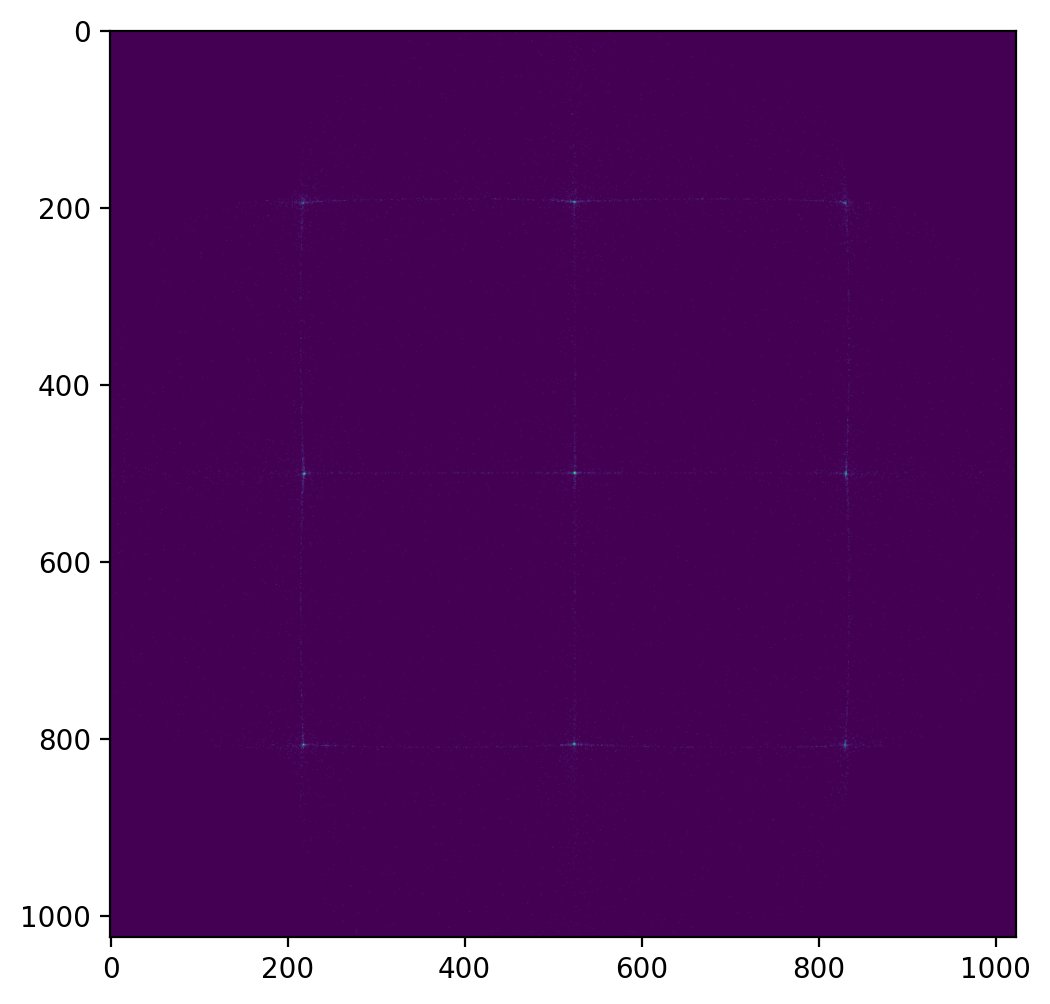

In [7]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)
plt.imshow(img_arr)
plt.show()


In [ ]:
nscalings = 50
n_scaling_list = np.linspace(1e-7, 2e-5, nscalings)

images = np.zeros((1024,1024, nscalings))

for n in range(0, len(n_scaling_list)):
    img = image_pybind.SmallImage(
        viewReso.x,
        viewReso.y,
        viewReso.z
    )
    n_scaling = n_scaling_list[n]
    scene.set_n_scaling(n_scaling)
    renderer.renderImage(img, medium, scene, numPhotons)
    
    (xres, yres, zres) = (img.getXRes(), img.getYRes(), img.getZRes())
    pixels = []
    for x in range(xres):
        for y in range(yres):
            for z in range(zres):
                pixels.append(img.getPixel(x, y, z))

    img_arr = np.array(pixels)
    img_arr = img_arr.reshape((xres, yres, zres))
    
    images[:,:,n] = np.squeeze(img_arr)
    

In [ ]:
n_scaling_list

In [ ]:
import imageio; 
from IPython.display import Video; 
imageio.mimwrite('del.mp4', images, fps=3); 
Video('del.mp4', width=1024, height=1024) #the width and height option as additional thing new in Ipython 7.6.1


In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)
plt.imshow(images_phases[:,:,0])
plt.show()

In [ ]:
import imageio; from IPython.display import Video; 
imageio.mimwrite('test2.mp4', images.to, fps=30); 
Video('test2.mp4')

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images

fig = plt.figure(figsize=(8, 6), dpi=125)

im = plt.imshow(video[:,:,0])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[:,:,0]*5)

def animate(i):
    im.set_data(video[:,:,i]*5)
    return im

anim1 = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[2],
                               interval=100,)
HTML(anim1.to_html5_video())

In [ ]:
%%time 
n_scaling = 0.8e-05
scene.set_n_scaling(n_scaling)


nphases = 50
phases1 = np.linspace(0, 2*math.pi, nphases)

images_phases = np.zeros((1024,1024, nphases))

for n in range(0, len(phases1)):
    img = image_pybind.SmallImage(
        viewReso.x,
        viewReso.y,
        viewReso.z
    )
    phase1 = phases1[n]
    scene.set_phase1(phase1)
    renderer.renderImage(img, medium, scene, numPhotons)
    
    (xres, yres, zres) = (img.getXRes(), img.getYRes(), img.getZRes())
    pixels = []
    for x in range(xres):
        for y in range(yres):
            for z in range(zres):
                pixels.append(img.getPixel(x, y, z))

    img_arr = np.array(pixels)
    img_arr = img_arr.reshape((xres, yres, zres))
    
    images_phases[:,:,n] = np.squeeze(img_arr)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images_phases

fig = plt.figure(figsize=(8, 6), dpi=125)
im = plt.imshow(video[:,:,0])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[:,:,0]*10)

def animate(i):
    im.set_data(video[:,:,i]*10)
    return im

anim1 = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[2],
                               interval=50,)
HTML(anim1.to_html5_video())

In [ ]:
phases1

In [ ]:
%%time 
n_scaling = 0.8e-05
scene.set_n_scaling(n_scaling)


phases1 = np.array([4.3157, 4.3157, 4.2523, 4.1253, 3.8080, 3.6811, 3.6176, 3.5541, 3.4272, 3.3637, 3.3003, 3.1733, 2.9829, 3.3003, 2.9829, 2.8560, 2.7291, 2.6021, 2.4752, 2.3483, 2.2213, 3.3003, 3.3003, 3.3003, 2.0309, 1.9040, 1.7771, 1.6501, 1.8405, 1.8405, 1.9040, 3.3003, 2.1579, 2.2213, 2.3483, 2.4752, 2.6021, 3.3003, 2.8560, 2.9195, 2.9829, 3.2368, 3.1733, 3.2368, 3.3637, 3.4907, 3.6811, 3.8715, 4.0619, 4.1888, 4.3157])
phases2 = np.array([1.3963, 1.4597, 1.5232, 1.5867, 1.7136, 1.7771, 1.8405, 1.9040, 1.9675, 2.0309, 2.0944, 2.1579, 2.2213, 2.2213, 2.2848, 2.3483, 2.4117, 2.4752, 2.5387, 2.6021, 2.6656, 2.6656, 2.7291, 2.7925, 2.8560, 2.9195, 2.9829, 3.0464, 3.0464, 3.1099, 3.1733, 3.1733, 3.2368, 3.3003, 3.3637, 3.4272, 3.4907, 3.4907, 3.5541, 3.6176, 3.6811, 3.6811, 3.7445, 3.8080, 3.8715, 3.9349, 3.9984, 4.0619, 4.1253, 4.1888, 4.2523])
nphases = len(phases1)


images_A_phases = np.zeros((1024,1024, nphases))

for n in range(0, len(phases1)):
    img = image_pybind.SmallImage(
        viewReso.x,
        viewReso.y,
        viewReso.z
    )
    phase1 = phases1[n]
    phase2 = phases2[n]
    scene.set_phase1(phase1)
    scene.set_phase2(phase2)
    renderer.renderImage(img, medium, scene, numPhotons)
    
    (xres, yres, zres) = (img.getXRes(), img.getYRes(), img.getZRes())
    pixels = []
    for x in range(xres):
        for y in range(yres):
            for z in range(zres):
                pixels.append(img.getPixel(x, y, z))

    img_arr = np.array(pixels)
    img_arr = img_arr.reshape((xres, yres, zres))
    
    images_A_phases[:,:,n] = np.squeeze(img_arr)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images_A_phases

fig = plt.figure(figsize=(8, 6), dpi=125)
im = plt.imshow(video[:,:,0])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[:,:,0]*10)

def animate(i):
    im.set_data(video[:,:,i]*10)
    return im

anim1 = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[2],
                               interval=100,)
HTML(anim1.to_html5_video())

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=200)
plt.imshow(np.sum(images_A_phases, axis=2))
plt.show()
